# Brain Tumour Multi-Classification and Clustering

> Nikin Baidar  
> Submission (Phase 1): Fri Apr 15 2022  
> Submission (Phase 2): Fri Apr 29 2022

##### Import modules!

In [127]:
# Py general
import numpy
import pandas
import os
import pathlib
import random

# Images/figures
from matplotlib import pyplot
from matplotlib import figure
from cv2 import imread
from cv2 import resize
from cv2 import IMREAD_GRAYSCALE

# Data perping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Models
from keras.models import Sequential
from keras.models import Model

# Layers
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

# Activation functions
from keras.layers import ReLU
from keras.layers import LeakyReLU
from keras.layers import PReLU
from keras.layers import Softmax

# Callbacks
from keras.callbacks import EarlyStopping

# Optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

# HP tuners
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Performancec evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##### Specify the project's root directory.

In [107]:
project_root = pathlib.Path.home().joinpath('projects/tumor_classification')

##### Images class definiton

In [108]:
class Images:
    """ A class with methods to import and prepare images and also 
    learn the class distribution.
    
    # Args:
      * img_size
      * validation_ratio
      * random_state
    
    # Class methods:
      * getClassDistribution
      * shuffleData
      * getRandomImage
    """
    
    ####################
    # Class attributes #
    ####################

    labels =  {
        'glioma_tumor'    : 0,
        'meningioma_tumor': 1,
        'no_tumor'        : 2,
        'pituitary_tumor' : 3
    }
    
    # Specify paths
    training_set_dir = project_root.joinpath('mri_dataset/Training')
    testing_set_dir  = project_root.joinpath('mri_dataset/Testing')
    
    def __init__(self, img_size, validation_ratio=None, random_state=101):
        
        global img_shape
    
        img_shape = (img_size, img_size, 1)
        
        self.random_state = random_state
        self.img_size = (img_size, img_size)
        self.X_train  = []
        self.Y_train  = []
        self.X_test   = []
        self.Y_test   = []
        
        # Import the training set.
        for label in self.labels.keys():
            input_dir = self.training_set_dir.joinpath(label)
            for item in os.listdir(input_dir):
                img_path  = input_dir.joinpath(item).as_posix()
                input_img = imread(img_path, IMREAD_GRAYSCALE) * (1/255.0)
                input_img = resize(input_img, self.img_size)
                self.X_train.append(input_img)
                self.Y_train.append(self.labels[label])
                
        # Import the test set.
        for label in self.labels.keys():
            input_dir = self.testing_set_dir.joinpath(label)
            for item in os.listdir(input_dir):
                path = input_dir.joinpath(item).as_posix()
                input_img = imread(path, IMREAD_GRAYSCALE) * (1/255.0)
                input_img = resize(input_img, self.img_size)
                self.X_test.append(input_img)
                self.Y_test.append(self.labels[label])
                
        # Change things into numpy arrays.
        self.x_train = numpy.array(self.X_train)
        self.y_train = numpy.array(self.Y_train)
        self.x_test  = numpy.array(self.X_test)
        self.y_test  = numpy.array(self.Y_test)
        # Reshape inputs
        self.x_train = self.x_train.reshape(-1, img_size, img_size, 1)
        self.x_test  = self.x_test.reshape(-1, img_size, img_size, 1)
        # Reshape plus encode labels/outputs
        self.y_train = self.y_train.reshape(-1, 1)
        self.y_train = to_categorical(self.y_train)
        self.y_test  = self.y_test.reshape(-1)
        
        # If validation_ratio is provided create a validation set.
        if validation_ratio:
            self.x_train, self.x_val , self.y_train, self.y_val =  \
            train_test_split(
                self.x_train,
                self.y_train,
                test_size=validation_ratio,
                random_state=self.random_state
            )
            self.Y_val   = list(numpy.argmax(self.y_val, axis=1))
            self.Y_train = list(numpy.argmax(self.y_train, axis=1))
        
    #######################################
    # Class methods pertaining to phase 1 #
    #######################################
    
    def getClassDistribution(self, mode='training', visualize=False):
        """Return a pandas dataframe with class distribution information."""
        if mode in 'training':
            classes = self.Y_train
        elif mode in 'test':
            classes = self.Y_test
        elif mode in 'validation':
            classes = self.Y_val
        else: 
            return None
        self.class_frequencies  = [classes.count(self.labels[label])
                                   for label in self.labels]
        self.class_distribution = [count/len(classes)
                                   for count in self.class_frequencies]
        data = {
            'classes'     : self.labels.keys(), 
            'value_count' : self.class_frequencies,
            'distribution': self.class_distribution
        }
        table = pandas.DataFrame(data)
        if visualize:
            pyplot.bar(self.labels.keys(), self.class_frequencies, width=0.4,
                       color=['#7EA8B4', '#A17544', '#D1D1CC', '#7F8C83'])
            pyplot.grid(linewidth=0.5, axis='y', linestyle='--' )
            pyplot.title(f'Class distribution in the {mode} set.')
        return table
        
    def shuffleData(self, mode='training'):
        """Shuffles the data in the training (or the specified) dataset."""
        if mode == 'training':
            self.x_train, self.y_train = shuffle(self.x_train, self.y_train)
        elif mode == 'test':
            self.x_test, self.y_test = shuffle(self.x_test, self.y_test)
        elif mode == 'validation':
            self.x_val, self.y_val = shuffle(self.x_val, self.y_val)
    
    def getRandomImage(self, mode='training', label=None, printLabel=False):
        """Fetches random images from the training (or the specified)
        dataset. If label is given, random images are selected from that
        class."""
        if mode == 'training':
            x, y = self.x_train, list(numpy.argmax(self.y_train, axis=1))
        elif mode == 'test':
            x, y = self.x_test, self.y_test
        elif mode == 'validation':
            try:
                x, y = self.x_val, list(numpy.argmax(self.y_val, axis=1))
            except:
                print('Validation set not defined.')
                return None
            
        label = self.labels.get(label, 4)
        if label < 4:
            tumour_class_index = 4
            while not tumour_class_index == label:
                fig = random.randrange(0, len(y))
                tumour_class_index = y[fig]
        else:
            fig = random.randrange(len(y))
            tumour_class_index = y[fig]
        tumour_class = list(self.labels.keys())[tumour_class_index]
        img = x[fig]
        if printLabel:
            print(tumour_class)
        return img
        
    ########################################
    # Class methods  pertaining to phase 2 #
    ########################################
    
    ## Maybe add methos for preprocessing images later.

## Phase 1

#### 1. Convert Images to 2D numpy array and back. [Show examples]
---

In [109]:
tumours = Images(128, validation_ratio=0.21)
tumours.shuffleData(mode='training')

In [111]:
alphaurs.getClassDistribution(mode='training')

,classes,value_count,distribution
0,glioma_tumor,643,0.283635
1,meningioma_tumor,642,0.283194
2,no_tumor,320,0.141156
3,pituitary_tumor,662,0.292016


<class 'numpy.ndarray'>
(128, 128, 1)



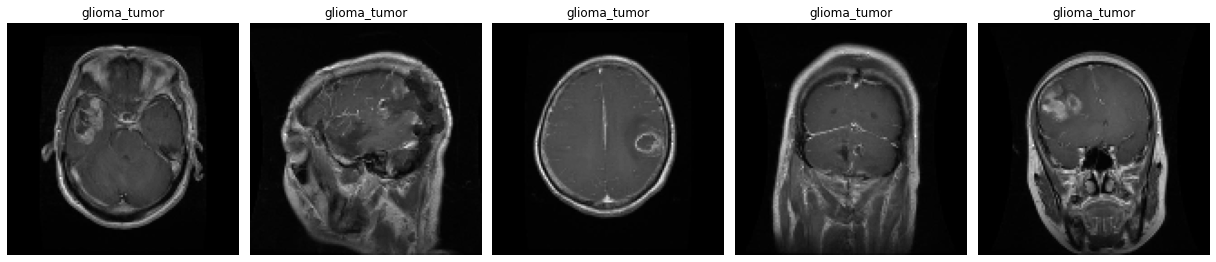

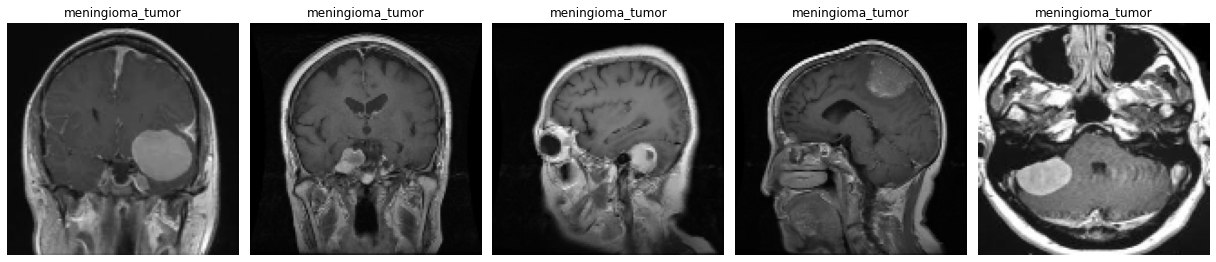

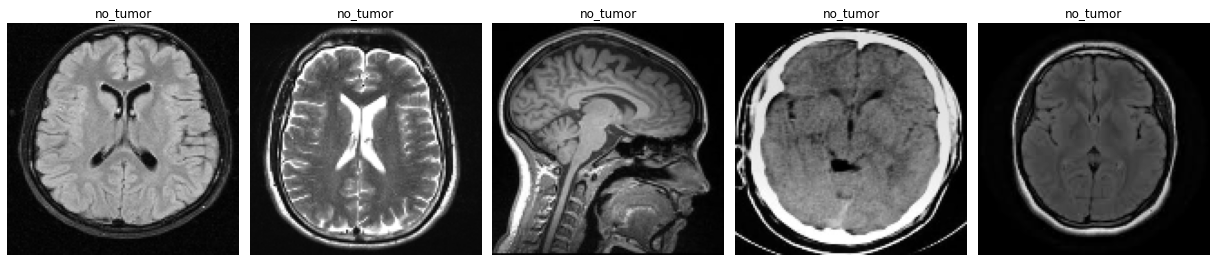

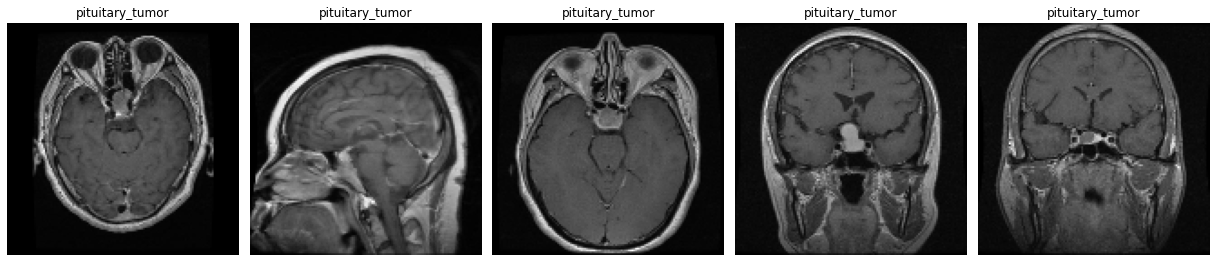

In [110]:
# Conversion to 2D numpy array
img = tumours.getRandomImage()
print(type(img))
print(img.shape)
print()

# And back
for key in tumours.labels:
    figure, axes = pyplot.subplots(1, 5, figsize=(17,17))
    for axis in axes.flatten():
        img = tumours.getRandomImage(mode='training', label=key)
        axis.imshow(img, cmap='gray')
        axis.set_title(key)
        axis.axis('off')
        pyplot.tight_layout()

#### 2. Set up a basic CNN network to classify different tumor types. 
---

In [112]:
class CNNModel:
    """CNNModel class represents a convolutional neural net and defines
    methods to train, test, and validate the model. Other methods are
    also defined to assess the model performance and improve upon it.

    Create a sequential Convolutional Neural Network model. Add layers
    to the neural net and then compile it. The layers are added in the
    following pattern:
    
    %======================================================%
    % CONV -> [CONV -> DROPOUT? -> POOL]*M -> FLAT -> FC*2 %
    %======================================================%
    where,
      - -> represents the flow of the neural net.
      - * represents repetition.
      - CONV means a convolution layer.
      - DROPOUT? represents an optional dropout layer.
      - POOL represents a pooling layer.
      - M is the depth i.e. the number of hidden layers.
      - FLAT represents a flat layer (2D -> 1D)
      - FC means a fully connected dense layer.
    > NB: 1 CONV, 1 POOL plus a DROPoUT? collecitvely make a single
    > hidden layer unit.
  
    # Args:
      * depth (default 3): Number of hidden layers in the neural net.
      * filters (default 8):
      * kernel_size (default 3):
      * optimizer (default Adam): The optimizing algorithm.
      * loss_function (default 'categorical_crossentropy').
      * activation (default ReLU): Activation used for the 
        outputs of the input and the hidden layers.
      * addDropouts (default False): Add dropouts if model overfits.
  
    # Class Methods:
      * __init__
      * describe
      * train
      * getDataPoints
      * plotLosses
      * makePrediction
      * getConfusionMatrix
      * getClassificationReport
      * evaluate
      * finalTest
      * getConvLayers
      * extractFilters
      * displayFeatures
    """
    
    ####################
    # Class attributes #
    ####################
  
    depth       = 3
    filters     = 8
    kernel_size = (3,3)
    strides     = 1
    padding     = 'same'
    optimizer   = Adam()
    activation  = ReLU()
    loss        = 'categorical_crossentropy'
  
    def __init__(self, depth=depth, filters=filters, kernel_size=kernel_size,
                 strides=strides, padding=padding, optimizer=optimizer,
                 activation=activation, addDropouts=False):
        """Compiles the neural net."""
        self.classifier  = Sequential()
        self.input_shape = img_shape
        self.depth       = depth
        self.filters     = filters
        self.kernel_size = kernel_size
        self.strides     = strides
        self.padding     = padding
        self.optimizer   = optimizer
        self.activation  = activation

        # Start adding layers to the classifier.
        self.classifier.add(
            Conv2D(
                filters=self.filters,
                kernel_size=self.kernel_size,
                padding=self.padding,
                strides=1,
                activation=self.activation,
                input_shape=self.input_shape,
                name='input'
            )
        )
        
        for count in range(depth):
            self.filters *= 2 # Linearly increase #filters as you go deeper. 
            self.classifier.add(
                Conv2D(
                    filters=self.filters,
                    kernel_size=self.kernel_size,
                    strides=2,
                    padding='same',
                    activation=self.activation,
                    name=f'conv{count + 1}'
                )
            )
            if addDropouts:
                self.classifier.add(
                    Dropout(0.3, name=f'drop{count + 1}')
                )
            self.classifier.add(
                MaxPooling2D(
                    pool_size=(2,2),
                    strides=2,
                    name=f'pool{count + 1}'
                )
            )

        self.classifier.add(Flatten(name='flat{}'.format(count := count+2)))
        
        self.classifier.add(
            Dense(
                units=8,
                activation='sigmoid',
                name='dense{}'.format(count := count+1)
            )
        )
        
        self.classifier.add(Dense(units=4, activation=Softmax(), name='output'))
    
        self.classifier.compile(
            optimizer=self.optimizer,
            loss=self.loss,
            metrics=['accuracy']
        )
        
        # For the second phase.
        self.convLayers = [index for (index, layer) 
                           in enumerate(self.classifier.layers)
                           if isinstance(layer, Conv2D)]
        
        self.poolLayers = [index for (index, layer) 
                           in enumerate(self.classifier.layers)
                           if isinstance(layer, MaxPooling2D)]
        
    #######################################
    # Class methods pertaining to phase 1 #
    #######################################
    
    def describe(self):
        """Print the classifier summary."""
        return self.classifier.summary()
        
    def train (self, x, y, epochs=10, batch_size=32, class_weight=None, 
               validation_data=None, showProgress=False):
        """Trains an instance of class CNNclassifier on a dataset and
        returns a history object with the training history.
    
        ## Args:
           * x, y: input and labels 
           * epochs (default 10): Number of epochs to train the
             classifier. An epoch is an iteration over the entire
             dataset. 
           * class_weight: A dict object that maps labels to a weight.
             Tells the classifier to "pay more attention" to samples 
             from an under-represented class.
           * validation_data: Dataset on which to evaluate the loss and
             any classifier metrics at the end of each epoch.
           * patience (default 10): If validation_data is provided,
             the number of epochs after which training will stop if
             there isn't any progress.
           * showProgress: Enable/Disable verbosity.
        """
        callback_list=[]

        if validation_data:
            callback_list.append(EarlyStopping(
                monitor='val_loss', patience=0.4*epochs)
            )
        self.history = self.classifier.fit(
            x, y,
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight,
            verbose=showProgress,
            validation_data=validation_data,
            callbacks=callback_list
        )
        
        self.history = self.history.history
    
    def getDataPoints(self, mode='loss'):
        """ Returns the losses during the training. Mode can be any one of 
        the keys of the History created during fitting."""
        return self.history[mode]
  
    def plotLosses(self):
        pyplot.plot(self.history['loss'], 'o-g', label="Training Losses")
        if 'val_loss' in self.history.keys():
            pyplot.plot(self.history['val_loss'], 'o--',
                        label="Validation Losses")
        pyplot.xlabel("Epochs")
        pyplot.ylabel("Losses")
        pyplot.title("Losses over Epochs")
        pyplot.legend()
        pyplot.grid(linewidth=0.5)
        pyplot.tight_layout()
  
    def makePrediction(self, x):
        """Predicts the classes of a the input x."""
        self.predicted_classes = self.classifier.predict(x)
  
    def getConfusionMatrix(self, true_classes):
        """Takes true classes and returns a confusion matrix as a pandas
        dataframe."""
        labels = Images.labels.keys()
        try:
            true_classes.shape[1]
            true_classes = numpy.argmax(true_classes, axis=1)
        except:
            pass
        predicted_classes = numpy.argmax(self.predicted_classes, axis=1)
        
        confusionMatrix = confusion_matrix(true_classes, predicted_classes)
        confusionMatrix = pandas.DataFrame(confusionMatrix, columns=labels)
        confusionMatrix.insert(0, 'labels', labels)
        print('\nConfusion Matrix:')
        print('='*17, end='\n'*2)
        print(confusionMatrix)
  
    def getClassificationReport(self, true_classes):
        try:
            true_classes.shape[1]
            true_classes = numpy.argmax(true_classes, axis=1)
        except:
            pass
        predicted_classes = numpy.argmax(self.predicted_classes, axis=1)
        
        classificationReport = classification_report(
            true_classes, predicted_classes, zero_division=0
        )
        print('\nClassification Report:')
        print('='*22, end='\n'*2)
        print(classificationReport)
        
    def evaluate(self):
        self.makePrediction(tumours.x_val)
        self.getConfusionMatrix(tumours.y_val)
        self.getClassificationReport(tumours.y_val)
        
    def finalTest(self):
        self.makePrediction(tumours.x_test)
        self.getConfusionMatrix(tumours.y_test)
        self.getClassificationReport(tumours.y_test)
        
    #######################################
    # Class methods pertaining to phase 2 #
    #######################################
 
    def extractFilters(self):
        """Extract the filters for the convolutional layers."""
        print('#'*35)
        print('# Filters of convolutional layers #')
        print('#'*35, end='\n'*2)
        filters = [self.classifier.layers[i].get_weights()[0]
                   for i in self.convLayers]
        layer_count = 0
        for filter_ in filters:
            filter_count = filter_.shape[-1]
            filter_depth = filter_.shape[-2]
            fig = pyplot.figure(figsize=(35,35))
            fig.suptitle(f'Layer_{self.convLayers[layer_count]}', fontsize=35)
            layer_count += 1
            for i in range(filter_count):
                pyplot.subplot(8, 8, i+1)
                pyplot.imshow(filter_[:,:,0,i], cmap='gray')
                pyplot.axis('off')
                pyplot.tight_layout(pad=3.0)
                pyplot.gcf().set_facecolor('orangered')
                        
    def displayFeatureMaps(self, layer_instance, image):
        if layer_instance == 'conv':
            layers = self.convLayers
            print('#'*36)
            print('# Features of convolutional layers #')
            print('#'*36, end='\n'*2)
        elif layer_instance == 'pool':
            layers = self.poolLayers
            print('#'*30)
            print('# Features of pooling layers #')
            print('#'*30, end='\n'*2)
        else:
            raise ValueError(f'{layer_instance} is not defined.')
            
        inputs  = self.classifier.inputs
        outputs = [self.classifier.layers[i].output for i in layers]
        fmapper = Model(inputs=inputs, outputs=outputs)
        image   = numpy.expand_dims(image, axis=0)
        feature_maps = fmapper.predict(image)
        layer_count = 0
        for fmap in feature_maps:
            fmap_count = fmap.shape[-1]
            fmap_depth = fmap.shape[0]
            fig = pyplot.figure(figsize=(35,35))
            fig.suptitle(f'Layer_{layers[layer_count]}' , fontsize=40)
            layer_count += 1
            for i in range(fmap_count):
                pyplot.subplot(8, 8, i+1)
                pyplot.imshow(fmap[0,:,:,i] , cmap='gray')
                pyplot.axis('off')
                pyplot.tight_layout(pad=3.0)

#### 3. Report key metrics to quantify the performance of your neural network.
---

##### BaseModel

In [117]:
BaseModel = CNNModel()
BaseModel.describe()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       80        
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        1168      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 conv3 (Conv2D)              (None, 4, 4, 64)          18496     
                                                                 
 pool3 (MaxPooling2D)        (None, 2, 2, 64)        

In [118]:
%%time
BaseModel.train(
    tumours.x_train,
    tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    batch_size=32,
    epochs=10,
    showProgress=True
)

Epoch 1/10
71/71 [==============================] - 6s 72ms/step - loss: 1.2104 - accuracy: 0.4495 - val_loss: 1.0843 - val_accuracy: 0.5174
Epoch 2/10
71/71 [==============================] - 5s 74ms/step - loss: 1.0021 - accuracy: 0.5673 - val_loss: 0.9858 - val_accuracy: 0.5987
Epoch 3/10
71/71 [==============================] - 5s 74ms/step - loss: 0.9015 - accuracy: 0.6370 - val_loss: 0.9317 - val_accuracy: 0.6020
Epoch 4/10
71/71 [==============================] - 5s 74ms/step - loss: 0.8437 - accuracy: 0.6551 - val_loss: 0.8773 - val_accuracy: 0.6269
Epoch 5/10
71/71 [==============================] - 5s 74ms/step - loss: 0.8012 - accuracy: 0.6665 - val_loss: 0.8412 - val_accuracy: 0.6766
Epoch 6/10
71/71 [==============================] - 5s 74ms/step - loss: 0.7568 - accuracy: 0.7168 - val_loss: 0.7867 - val_accuracy: 0.7065
Epoch 7/10
71/71 [==============================] - 5s 74ms/step - loss: 0.7062 - accuracy: 0.7530 - val_loss: 0.7590 - val_accuracy: 0.7280
Epoch 8/10
71

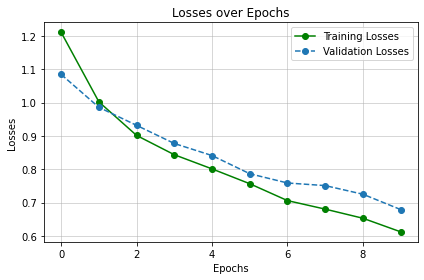

In [119]:
BaseModel.plotLosses()

##### Performance on test set.
---

,classes,value_count,distribution
0,glioma_tumor,100,0.253807
1,meningioma_tumor,115,0.291878
2,no_tumor,105,0.266497
3,pituitary_tumor,74,0.187817


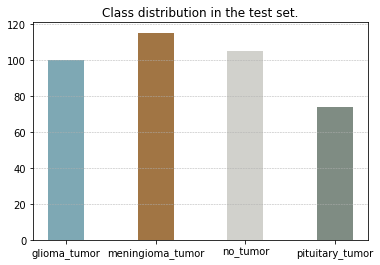

In [120]:
tumours.getClassDistribution(mode='test', visualize=True)

In [122]:
BaseModel.finalTest()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor             9                10        69               12
1  meningioma_tumor             1                10        97                7
2          no_tumor             0                 8        85               12
3   pituitary_tumor             1                13        36               24

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.09      0.16       100
           1       0.24      0.09      0.13       115
           2       0.30      0.81      0.43       105
           3       0.44      0.32      0.37        74

    accuracy                           0.32       394
   macro avg       0.45      0.33      0.27       394
weighted avg       0.44      0.32      0.26       394



##### Performance on validation set.
---

,classes,value_count,distribution
0,glioma_tumor,183,0.303483
1,meningioma_tumor,180,0.298507
2,no_tumor,75,0.124378
3,pituitary_tumor,165,0.273632


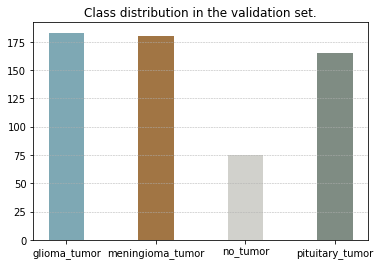

In [123]:
tumours.getClassDistribution(mode='validation', visualize=True)

In [124]:
BaseModel.evaluate()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           130                49         1                3
1  meningioma_tumor            28               114        25               13
2          no_tumor             1                 7        60                7
3   pituitary_tumor             3                 2         3              157

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       183
           1       0.66      0.63      0.65       180
           2       0.67      0.80      0.73        75
           3       0.87      0.95      0.91       165

    accuracy                           0.76       603
   macro avg       0.75      0.77      0.76       603
weighted avg       0.76      0.76      0.76       603



* The base model has a fairly good validation accuracy but the test accuracy is  really low.

#### 4. Set up a hyperparameter tuning mechanism to improve your performance metrics. Report performance on multiple scenarios tested. Different number of neurons/filter sizes? [At least 3 different types of hyperparameters should be tested with at least 3 different values]
---

##### Test 0: Batch Size

CPU times: user 4min 59s, sys: 4.79 s, total: 5min 4s
Wall time: 52.5 s


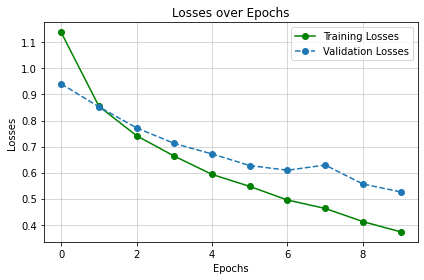

In [128]:
%%time
# Same architecture as the base model
alpha = CNNModel() 
alpha.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=16,
    validation_data=(tumours.x_val, tumours.y_val)
)
alpha.plotLosses()

In [129]:
alpha.evaluate()


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           143                33         3                4
1  meningioma_tumor            32               122        12               14
2          no_tumor             5                13        53                4
3   pituitary_tumor             4                 2         2              157

Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       183
           1       0.72      0.68      0.70       180
           2       0.76      0.71      0.73        75
           3       0.88      0.95      0.91       165

    accuracy                           0.79       603
   macro avg       0.78      0.78      0.78       603
weighted avg       0.78      0.79      0.79       603



* Reducing the batch size by half improved the f1 score by 2%.


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           141                32         0               10
1  meningioma_tumor            14               128        11               27
2          no_tumor             2                10        56                7
3   pituitary_tumor             0                 3         0              162

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       183
           1       0.74      0.71      0.73       180
           2       0.84      0.75      0.79        75
           3       0.79      0.98      0.87       165

    accuracy                           0.81       603
   macro avg       0.82      0.80      0.80       603
weighted avg       0.81      0.81      0.81       603

CPU times: user 5min 1s, sys: 6.8 s, total: 5min 8s
Wall time: 1min


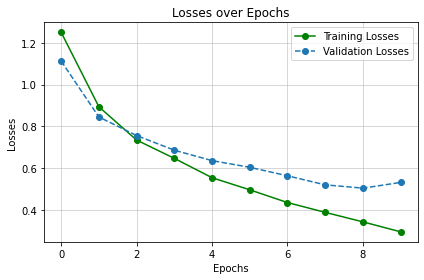

In [130]:
%%time
bravo = CNNModel() 
bravo.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=8,
    validation_data=(tumours.x_val, tumours.y_val)
)
bravo.plotLosses()

bravo.makePrediction(tumours.x_val)
bravo.getConfusionMatrix(tumours.y_val)
bravo.getClassificationReport(tumours.y_val)


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           130                50         0                3
1  meningioma_tumor            20               134        13               13
2          no_tumor             3                24        47                1
3   pituitary_tumor             3                10         0              152

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       183
           1       0.61      0.74      0.67       180
           2       0.78      0.63      0.70        75
           3       0.90      0.92      0.91       165

    accuracy                           0.77       603
   macro avg       0.78      0.75      0.76       603
weighted avg       0.78      0.77      0.77       603

CPU times: user 5min 3s, sys: 8.57 s, total: 5min 12s
Wall time: 49.5 s


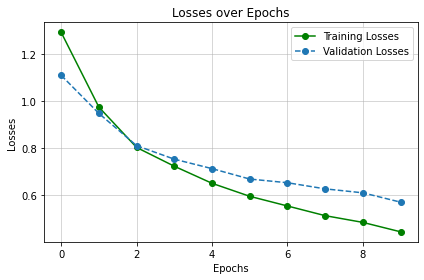

In [135]:
%%time
charlie = CNNModel() 
charlie.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val)
)
charlie.plotLosses()
charlie.evaluate()

* Increasing the batch size to 64 decrease the f1 score by almost 5%.  
To cope with this decrease depth and increase the number of epochs.

Epoch 1/20
36/36 [==============================] - 5s 122ms/step - loss: 1.2262 - accuracy: 0.4693 - val_loss: 1.1171 - val_accuracy: 0.5307
Epoch 2/20
36/36 [==============================] - 5s 142ms/step - loss: 1.0356 - accuracy: 0.5602 - val_loss: 1.0060 - val_accuracy: 0.5589
Epoch 3/20
36/36 [==============================] - 5s 140ms/step - loss: 0.9210 - accuracy: 0.6123 - val_loss: 0.9106 - val_accuracy: 0.5954
Epoch 4/20
36/36 [==============================] - 5s 138ms/step - loss: 0.8415 - accuracy: 0.6409 - val_loss: 0.8419 - val_accuracy: 0.6468
Epoch 5/20
36/36 [==============================] - 5s 137ms/step - loss: 0.7401 - accuracy: 0.7049 - val_loss: 0.7630 - val_accuracy: 0.6882
Epoch 6/20
36/36 [==============================] - 5s 137ms/step - loss: 0.6563 - accuracy: 0.7618 - val_loss: 0.7440 - val_accuracy: 0.7197
Epoch 7/20
36/36 [==============================] - 5s 136ms/step - loss: 0.6185 - accuracy: 0.7724 - val_loss: 0.7215 - val_accuracy: 0.7015
Epoch 

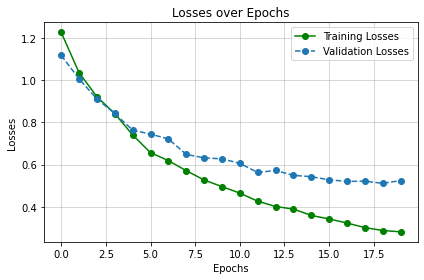

In [137]:
%%time
delta = CNNModel(depth=2) 
delta.train(
    tumours.x_train, tumours.y_train,
    epochs=20,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
delta.plotLosses()
delta.evaluate()

* Increasing the number of epochs seemed to have a positive affect on  
the overall model performance, although the computation time was greater.


Confusion Matrix:

             labels  glioma_tumor  meningioma_tumor  no_tumor  pituitary_tumor
0      glioma_tumor           142                37         0                4
1  meningioma_tumor             9               150        11               10
2          no_tumor             2                10        62                1
3   pituitary_tumor             1                 5         1              158

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       183
           1       0.74      0.83      0.79       180
           2       0.84      0.83      0.83        75
           3       0.91      0.96      0.93       165

    accuracy                           0.85       603
   macro avg       0.85      0.85      0.85       603
weighted avg       0.86      0.85      0.85       603

CPU times: user 12min 43s, sys: 15.1 s, total: 12min 58s
Wall time: 2min 2s


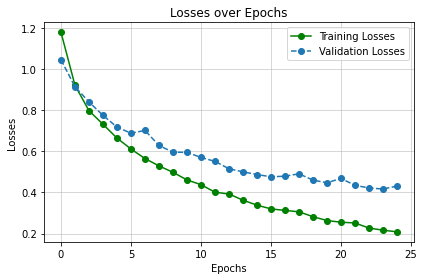

In [138]:
%%time
echo = CNNModel(depth=2) 
echo.train(
    tumours.x_train, tumours.y_train,
    epochs=25,
    batch_size=64,
    validation_data=(tumours.x_val, tumours.y_val),
)
echo.plotLosses()
echo.evaluate()

In [139]:
echo.describe()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Conv2D)              (None, 128, 128, 8)       80        
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 16)        1168      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 8, 8, 32)          0         
                                                                 
 flat3 (Flatten)             (None, 2048)              0         
                                                                 
 dense4 (Dense)              (None, 8)               

##### Test 1: Filters, kernels and strides.

Epoch 1/10
23/23 [==============================] - 9s 398ms/step - loss: 1.3223 - accuracy: 0.3736 - val_loss: 1.1929 - val_accuracy: 0.5041
Epoch 2/10
23/23 [==============================] - 10s 422ms/step - loss: 1.1720 - accuracy: 0.5112 - val_loss: 1.1169 - val_accuracy: 0.5207
Epoch 3/10
23/23 [==============================] - 10s 426ms/step - loss: 1.0818 - accuracy: 0.5271 - val_loss: 1.0754 - val_accuracy: 0.5257
Epoch 4/10
23/23 [==============================] - 9s 413ms/step - loss: 1.0299 - accuracy: 0.5452 - val_loss: 1.0222 - val_accuracy: 0.5423
Epoch 5/10
23/23 [==============================] - 10s 417ms/step - loss: 0.9728 - accuracy: 0.5434 - val_loss: 0.9607 - val_accuracy: 0.5489
Epoch 6/10
23/23 [==============================] - 10s 415ms/step - loss: 0.9213 - accuracy: 0.5584 - val_loss: 0.9402 - val_accuracy: 0.5755
Epoch 7/10
23/23 [==============================] - 10s 424ms/step - loss: 0.8912 - accuracy: 0.6299 - val_loss: 0.8955 - val_accuracy: 0.6534
E

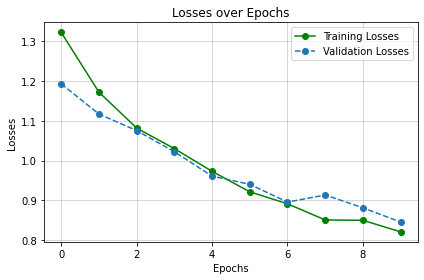

In [141]:
%%time
foxtrot = CNNModel(filters=16) 

foxtrot.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    batch_size=100,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
foxtrot.plotLosses()
foxtrot.evaluate()

In [144]:
tumours.shuffleData()

Epoch 1/15
71/71 [==============================] - 56s 781ms/step - loss: 1.1955 - accuracy: 0.4477 - val_loss: 1.1225 - val_accuracy: 0.5489
Epoch 2/15
71/71 [==============================] - 55s 772ms/step - loss: 1.0303 - accuracy: 0.5761 - val_loss: 1.0076 - val_accuracy: 0.5920
Epoch 3/15
71/71 [==============================] - 55s 775ms/step - loss: 0.8882 - accuracy: 0.6392 - val_loss: 0.8913 - val_accuracy: 0.6285
Epoch 4/15
71/71 [==============================] - 54s 763ms/step - loss: 0.8010 - accuracy: 0.6811 - val_loss: 0.7885 - val_accuracy: 0.7081
Epoch 5/15
71/71 [==============================] - 55s 771ms/step - loss: 0.6914 - accuracy: 0.7481 - val_loss: 0.7364 - val_accuracy: 0.7181
Epoch 6/15
71/71 [==============================] - 54s 761ms/step - loss: 0.6466 - accuracy: 0.7653 - val_loss: 0.6810 - val_accuracy: 0.7413
Epoch 7/15
71/71 [==============================] - 54s 763ms/step - loss: 0.5674 - accuracy: 0.8019 - val_loss: 0.6084 - val_accuracy: 0.7778

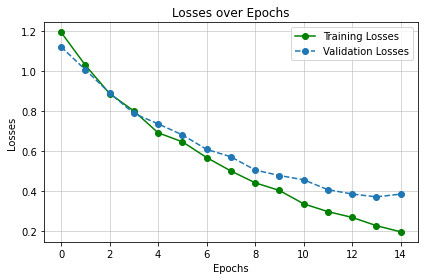

In [145]:
golf = CNNModel(filters=64, strides=2) 

golf.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
golf.plotLosses()
golf.evaluate()

Epoch 1/10
71/71 [==============================] - 54s 764ms/step - loss: 0.1665 - accuracy: 0.9727 - val_loss: 0.3495 - val_accuracy: 0.8905
Epoch 2/10
71/71 [==============================] - 54s 763ms/step - loss: 0.1568 - accuracy: 0.9713 - val_loss: 0.3368 - val_accuracy: 0.8922
Epoch 3/10
71/71 [==============================] - 54s 765ms/step - loss: 0.1246 - accuracy: 0.9819 - val_loss: 0.3584 - val_accuracy: 0.8789
Epoch 4/10
71/71 [==============================] - 54s 764ms/step - loss: 0.1076 - accuracy: 0.9841 - val_loss: 0.3263 - val_accuracy: 0.8922
Epoch 5/10
71/71 [==============================] - 54s 764ms/step - loss: 0.0990 - accuracy: 0.9859 - val_loss: 0.3496 - val_accuracy: 0.8955
Epoch 6/10
71/71 [==============================] - 54s 763ms/step - loss: 0.0838 - accuracy: 0.9876 - val_loss: 0.3559 - val_accuracy: 0.8939
Epoch 7/10
71/71 [==============================] - 54s 766ms/step - loss: 0.0763 - accuracy: 0.9899 - val_loss: 0.3284 - val_accuracy: 0.8972

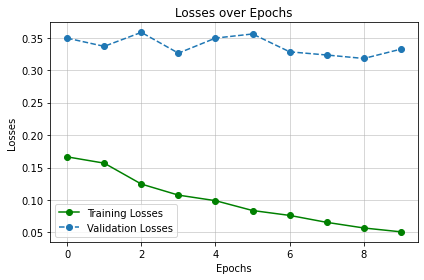

In [146]:
%%time
golf.train(
    tumours.x_train, tumours.y_train,
    epochs=10,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
golf.plotLosses()
golf.evaluate()

In [ ]:
hotel = CNNModel(filters=8, kernel_size=5) 
hotel.describe()

In [ ]:
hotel.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
hotel.plotLosses()
hotel.evaluate()

In [ ]:
%%time
india = CNNModel(filters=4, kernel_size=7) 
india.train(
    tumours.x_train, tumours.y_train,
    epochs=15,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
india.plotLosses()
india.evaluate()

In [ ]:
india.train(
    tumours.x_train, tumours.y_train,
    epochs=5,
    batch_size=50,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)

india.plotLosses()

In [ ]:
india.finalTest()

##### Test 2: Optimizers and Learning Rates

In [ ]:
tumours = Images(180, validation_ratio=0.15)
tumours.shuffleData(mode='training')
tumours.shuffleData(mode='validation')

In [ ]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100,
    decay_rate=0.9)

juliet = CNNModel(filters=16, kernel_size=5, optimizer=SGD(learning_rate=lr_schedule)) 
juliet.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
juliet.plotLosses()
juliet.evaluate()

In [ ]:
tumours = Images(180, validation_ratio=0.3)
tumours.shuffleData(mode='training')
tumours.shuffleData(mode='validation')

In [ ]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.9)

kilo = CNNModel(filters=20, kernel_size=3, optimizer=SGD(learning_rate=lr_schedule)) 
kilo.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
kilo.plotLosses()
kilo.evaluate()

In [ ]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.9,
    decay_steps=1000,
    decay_rate=0.9)
lima = CNNModel(filters=24, kernel_size=3, optimizer=SGD(learning_rate=lr_schedule)) 
lima.train(
    tumours.x_train, tumours.y_train,
    epochs=30,
    batch_size=32*4,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
lima.plotLosses()
lima.evaluate()

In [ ]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.2,
    decay_steps=10000,
    decay_rate=0.8)
mike = CNNModel(filters=16, optimizer=SGD(learning_rate=lr_schedule)) 
mike.train(
    tumours.x_train, tumours.y_train,
    epochs=40,
    validation_data=(tumours.x_val, tumours.y_val),
    showProgress=True
)
mike.plotLosses()
mike.evaluate()

In [ ]:
%%time
november = CNNModel(depth=4, optimizer=Adam(learning_rate=0.0008))
november.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=10,
    showProgress=True
)
november.plotLosses()
november.evaluate()

In [ ]:
%%time
oscar = CNNModel(depth=4, optimizer=Adam(learning_rate=0.0009))
oscar.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=30,
    showProgress=True
)
oscar.plotLosses()
oscar.evaluate()

In [ ]:
%%time
oscar.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    batch_size=1,
    epochs=10,
    showProgress=True
)
oscar.plotLosses()
oscar.evaluate()

In [ ]:
%%time
papa = CNNModel(depth=4, filters=32, optimizer=Adam(learning_rate=0.0009))
papa.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=20,
    showProgress=True
)
papa.plotLosses()
papa.evaluate()

In [ ]:
%%time
quebec = CNNModel(
    depth=3,
    kernel_size=4,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

quebec.describe()

quebec.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=100,
    showProgress=True
)

quebec.plotLosses()
quebec.evaluate()

In [ ]:
%%time
romeo = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

romeo.describe()

romeo.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    batch_size=64,
    epochs=100,
    showProgress=True
)

romeo.plotLosses()
romeo.evaluate()

In [ ]:
romeo.finalTest()

##### Cross-validation

In [ ]:
sierra = CNNModel(
    depth=3,
    kernel_size=5,
    filters=8,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0008)
)

In [ ]:
sierra.describe()

###### Show casing different sets for cross-validation.

In [ ]:
%%time
folds = 5

for i in range(folds):
    tumours = Images(180, validation_ratio=0.2, random_state=None)
    # tumours.shuffleData(mode='training')
    # tumours.shuffleData(mode='validation')
    validation_data_points = tumours.y_val.shape[0]
    training_data_points = tumours.y_train.shape[0]
    print('Starting cross-validation in fold {}'.format(i))
    print('='*35, end='\n'*2)
    print(f'Training on {training_data_points} datapoints and validating in' \
          f'{validation_data_points}')
    print(numpy.argmax(tumours.y_val, axis=1))
    print()
        
    

###### Performing cross validation on 5 folds.

In [ ]:
%%time
folds = 5

accuracy__ = numpy.zeros((folds))

for i in range(folds):
    tumours = Images(180, validation_ratio=0.2, random_state=None)
    tumours.shuffleData(mode='training')
    tumours.shuffleData(mode='validation')
    validation_data_points = tumours.y_val.shape[0]
    training_data_points = tumours.y_train.shape[0]
    print('#'*39)
    print(f'# Starting cross-validation in fold {i} #')
    print('#'*39, end='\n'*2)
    print(f'Training on {training_data_points} and validating in ' \
          f'{validation_data_points} datapoints.')
    print()
    
    print('Training in progress ...')
    
    sierra.train(
        tumours.x_train, tumours.y_train,
        validation_data=(tumours.x_val, tumours.y_val),
        batch_size=64,
        epochs=100,
    )

    print('Training complete! fetching performance report...')
    
    accuracy__[i] = max(sierra.getDataPoints(mode='accuracy'))
    sierra.makePrediction(tumours.x_val)
    sierra.getClassificationReport(tumours.y_val)

print(f'Mean accuracy : {numpy.mean(accuracy__)}')

In [ ]:
sierra.plotLosses()

In [ ]:
sierra.finalTest()

* If your model isn't generalizing over training, test and validation sets a cross-validation definitely seems to help.

##### Test 3: Experimenting 

In [ ]:
tumours = Images(180, validation_ratio=0.2)

In [ ]:
tango = CNNModel(
    depth=4,
    kernel_size=3,
    filters=32,
    strides=2,
    optimizer=Adam()
)

tango.describe()

In [ ]:
tango.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=10,
    showProgress=True
)

tango.plotLosses()
tango.evaluate()

In [ ]:
# Hyperparameter tuning example.
weights = {0: 1.2, 1:1.3, 2: 1.5, 3:1.4}

whisky = CNNModel(
    input_shape=image_shape,
    depth=3,
    kernel_size=4,
    filters=5,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.0009)
)

whisky.describe()

whisky.train(
    training_set.generator,
    validation_data=validation_set.generator,
    epochs=20,
    class_weight=weights,
    showProgress=True
)

whisky.plotLosses()

whisky.makePrediction(validation_set.generator)

print()
whisky.getConfusionMatrix(validation_set.classes, validation_set.labels)

In [ ]:
xray = CNNModel(
    depth=2,
    kernel_size=3,
    filters=16,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.001)
)

xray.describe()

xray.train(
    training_set.generator,
    validation_data=validation_set.generator,
    epochs=30,
    showProgress=True
)

xray.plotLosses()

xray.makePrediction(validation_set.generator)

print()
xray.getConfusionMatrix(validation_set.classes, validation_set.labels)

In [ ]:
yankee = CNNModel(
    input_shape=image_shape,
    depth=2,
    kernel_size=3,
    filters=16,
    addDropouts=True,
    optimizer=Adam(learning_rate=0.001)
)

yankee.describe()

yankee.train(
    training_set.generator,
    validation_data=validation_set.generator,
    epochs=10,
    showProgress=True
)

yankee.plotLosses()

yankee.makePrediction(validation_set.generator)

print()
yankee.getConfusionMatrix(validation_set.classes, validation_set.labels)

In [ ]:
%%time
zulu = CNNModel(
    depth=3,
    kernel_size=3,
    filters=46,
    activation=LeakyReLU()
)
zulu.describe()
zulu.train(
    tumours.x_train, tumours.y_train,
    validation_data=(tumours.x_val, tumours.y_val),
    epochs=10,
    showProgress=True
)
zulu.plotLosses()
zulu.evaluate()

In [ ]:
zulu.finalTest()

#### 5. Are you overfitting? Verify. 
---

#### 6. Can you apply additional techniques to improve the performance of your CNN? Dropout? Data-augmentation, etc.. 
---

#### 7. Extra credits for nice plots and great analytics!  training_history.history.keys()
---

## Phase 2

In [8]:
class FeatureMapper():
    def __init__(self, model, layers, image):
        if not isinstance(layers, list):
            raise ValueError(f'Expected a list but {type(layers)} was received.')
        self.inputs  = model.classifier.inputs
        self.outputs = [model.classifier.layers[i].output for i in layers]
        fmapper = Model(inputs=self.inputs, outputs=self.outputs)
        image = numpy.expand_dims(image, axis=0)
        self.feature_maps = fmapper.predict(image)
    
    def describe(self):
        self.fmapper.summary()

#### 1. Extract filters of your CNN from different layers. Convert them into images. What do they mean? 
---

In [9]:
# BaseModel.extractFilters(layer_index=1, figsize=(25,25))

* Inspection of the filters and the  feature map outputs of the
  convolutional layers allow us to understand what features are exactly being
  detected for a given input image.

* We can see that each channel has a different filter. This means each channel is
  looking for a different feature in the image. The darker pixels have smaller
  values and the brighter pixels have bigger values. With this in mind, we can
  see that most the filters above are looking for a darker object in the center.

* Looking at just the filters is not that intuitive, specially if the number of
  filters in a layer is large. We will now visualize the result of applying these
  filters to the input.

pituitary_tumor


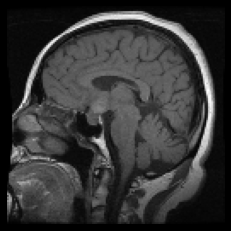

In [42]:
img = tumours.getRandomImage(printLabel=True)
pyplot.imshow(img, cmap='gray')
pyplot.axis('off')
pyplot.gcf().set_facecolor('black')

In [92]:
BaseModel = CNNModel()

###################################
# Filters of convolutional layers #
###################################



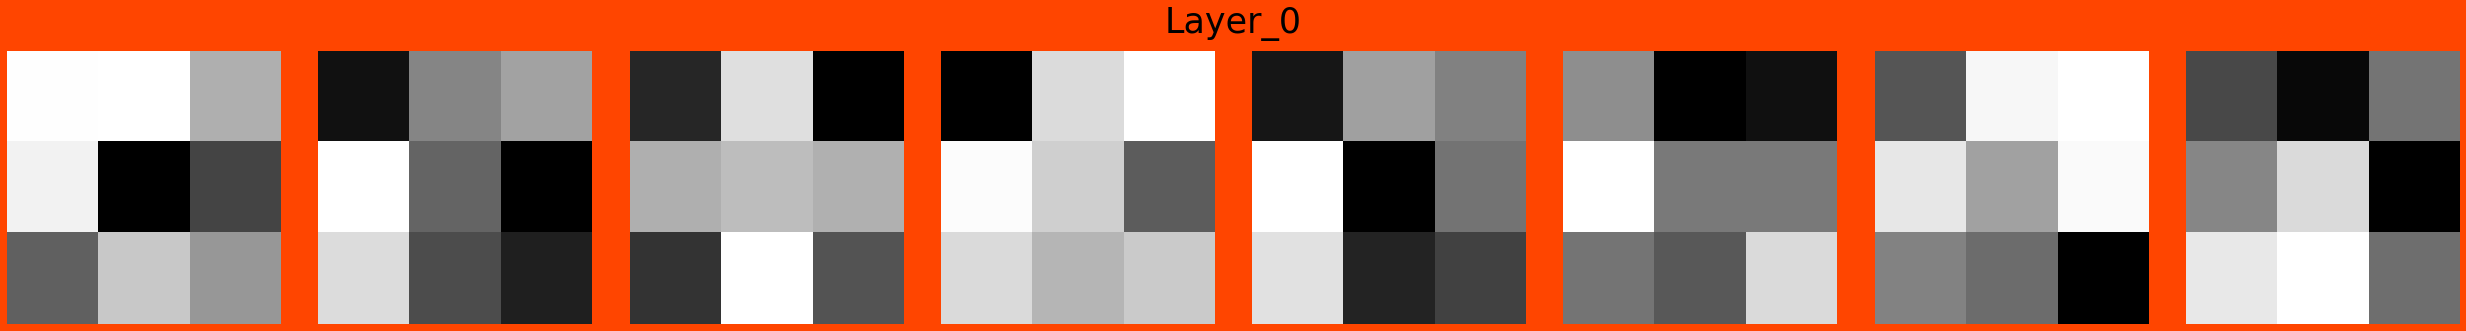

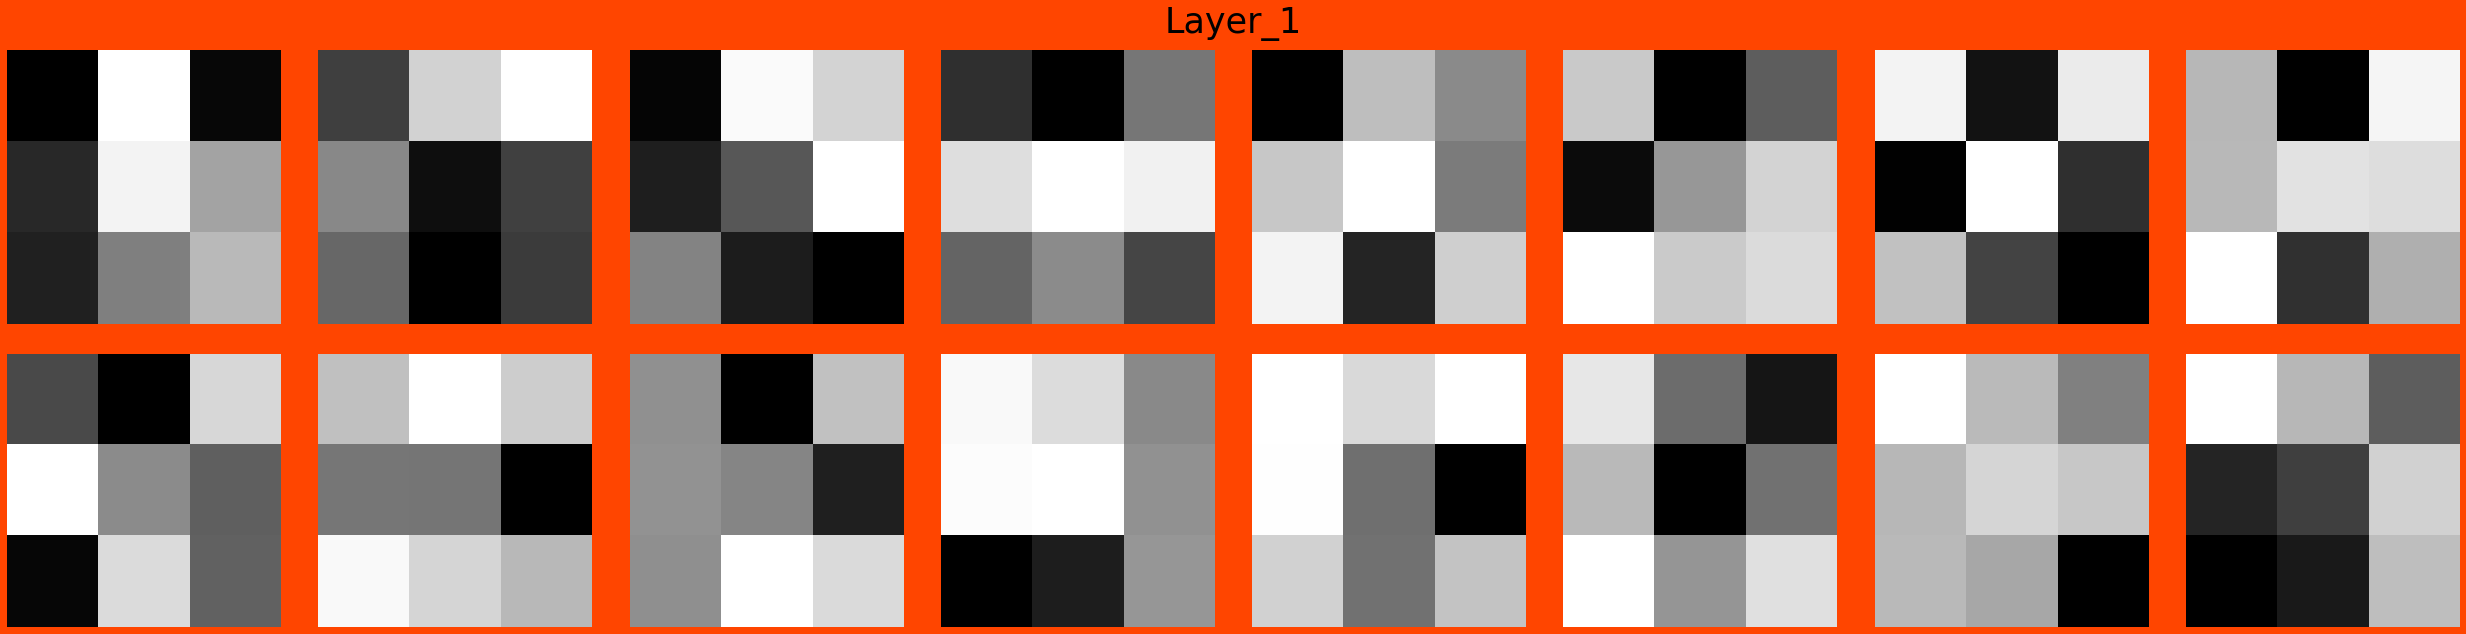

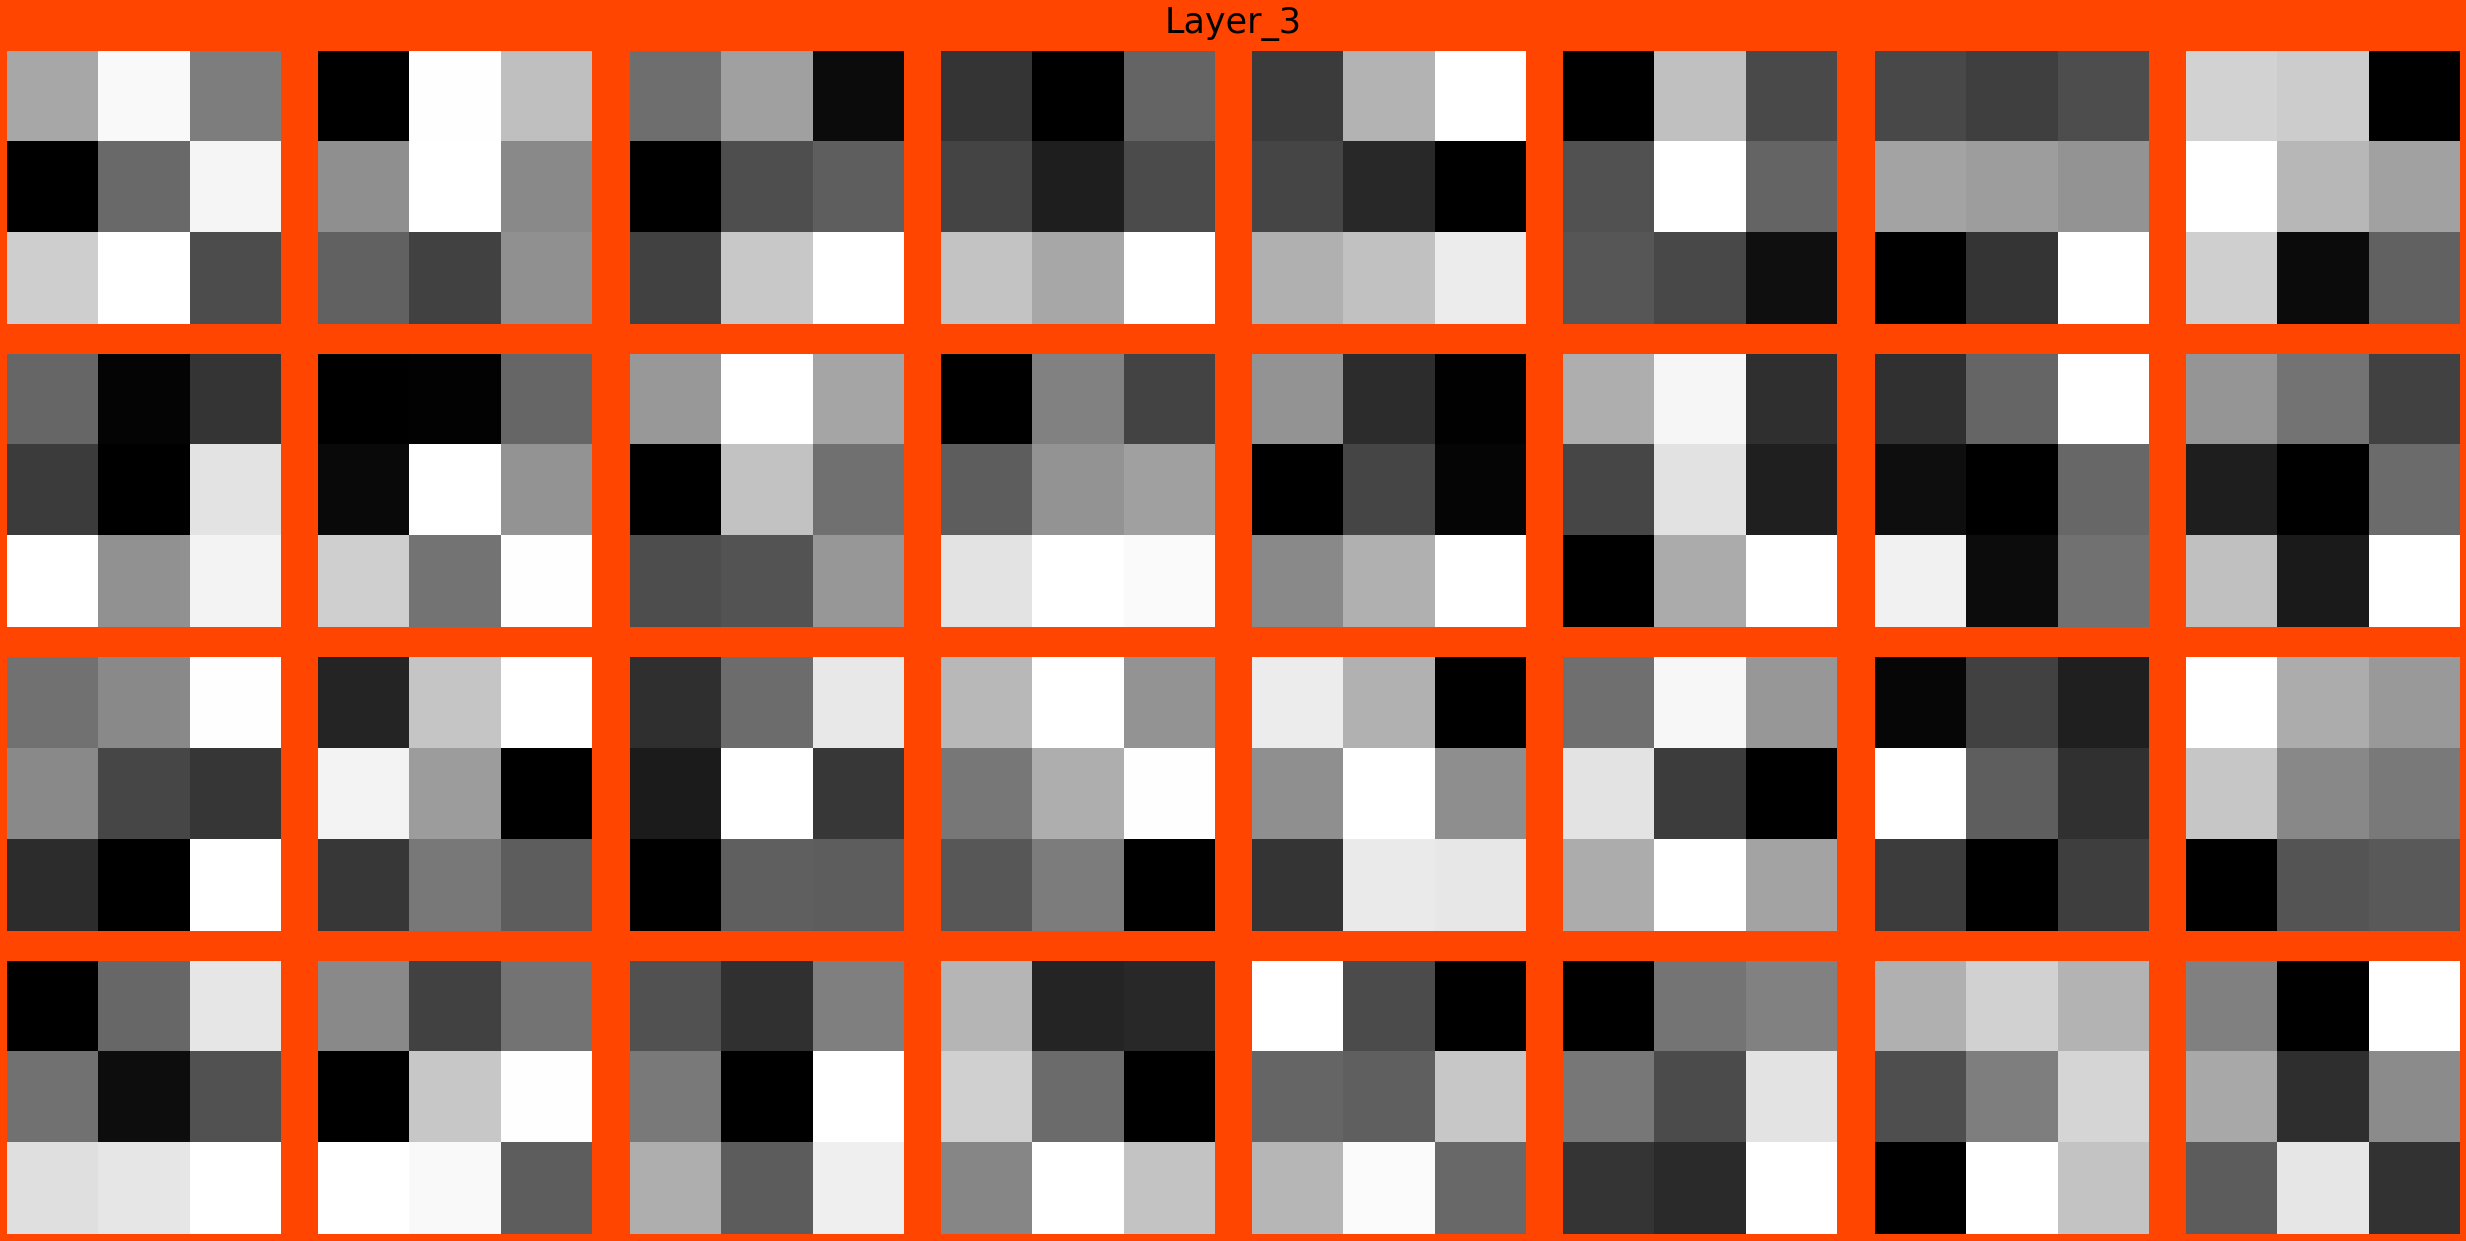

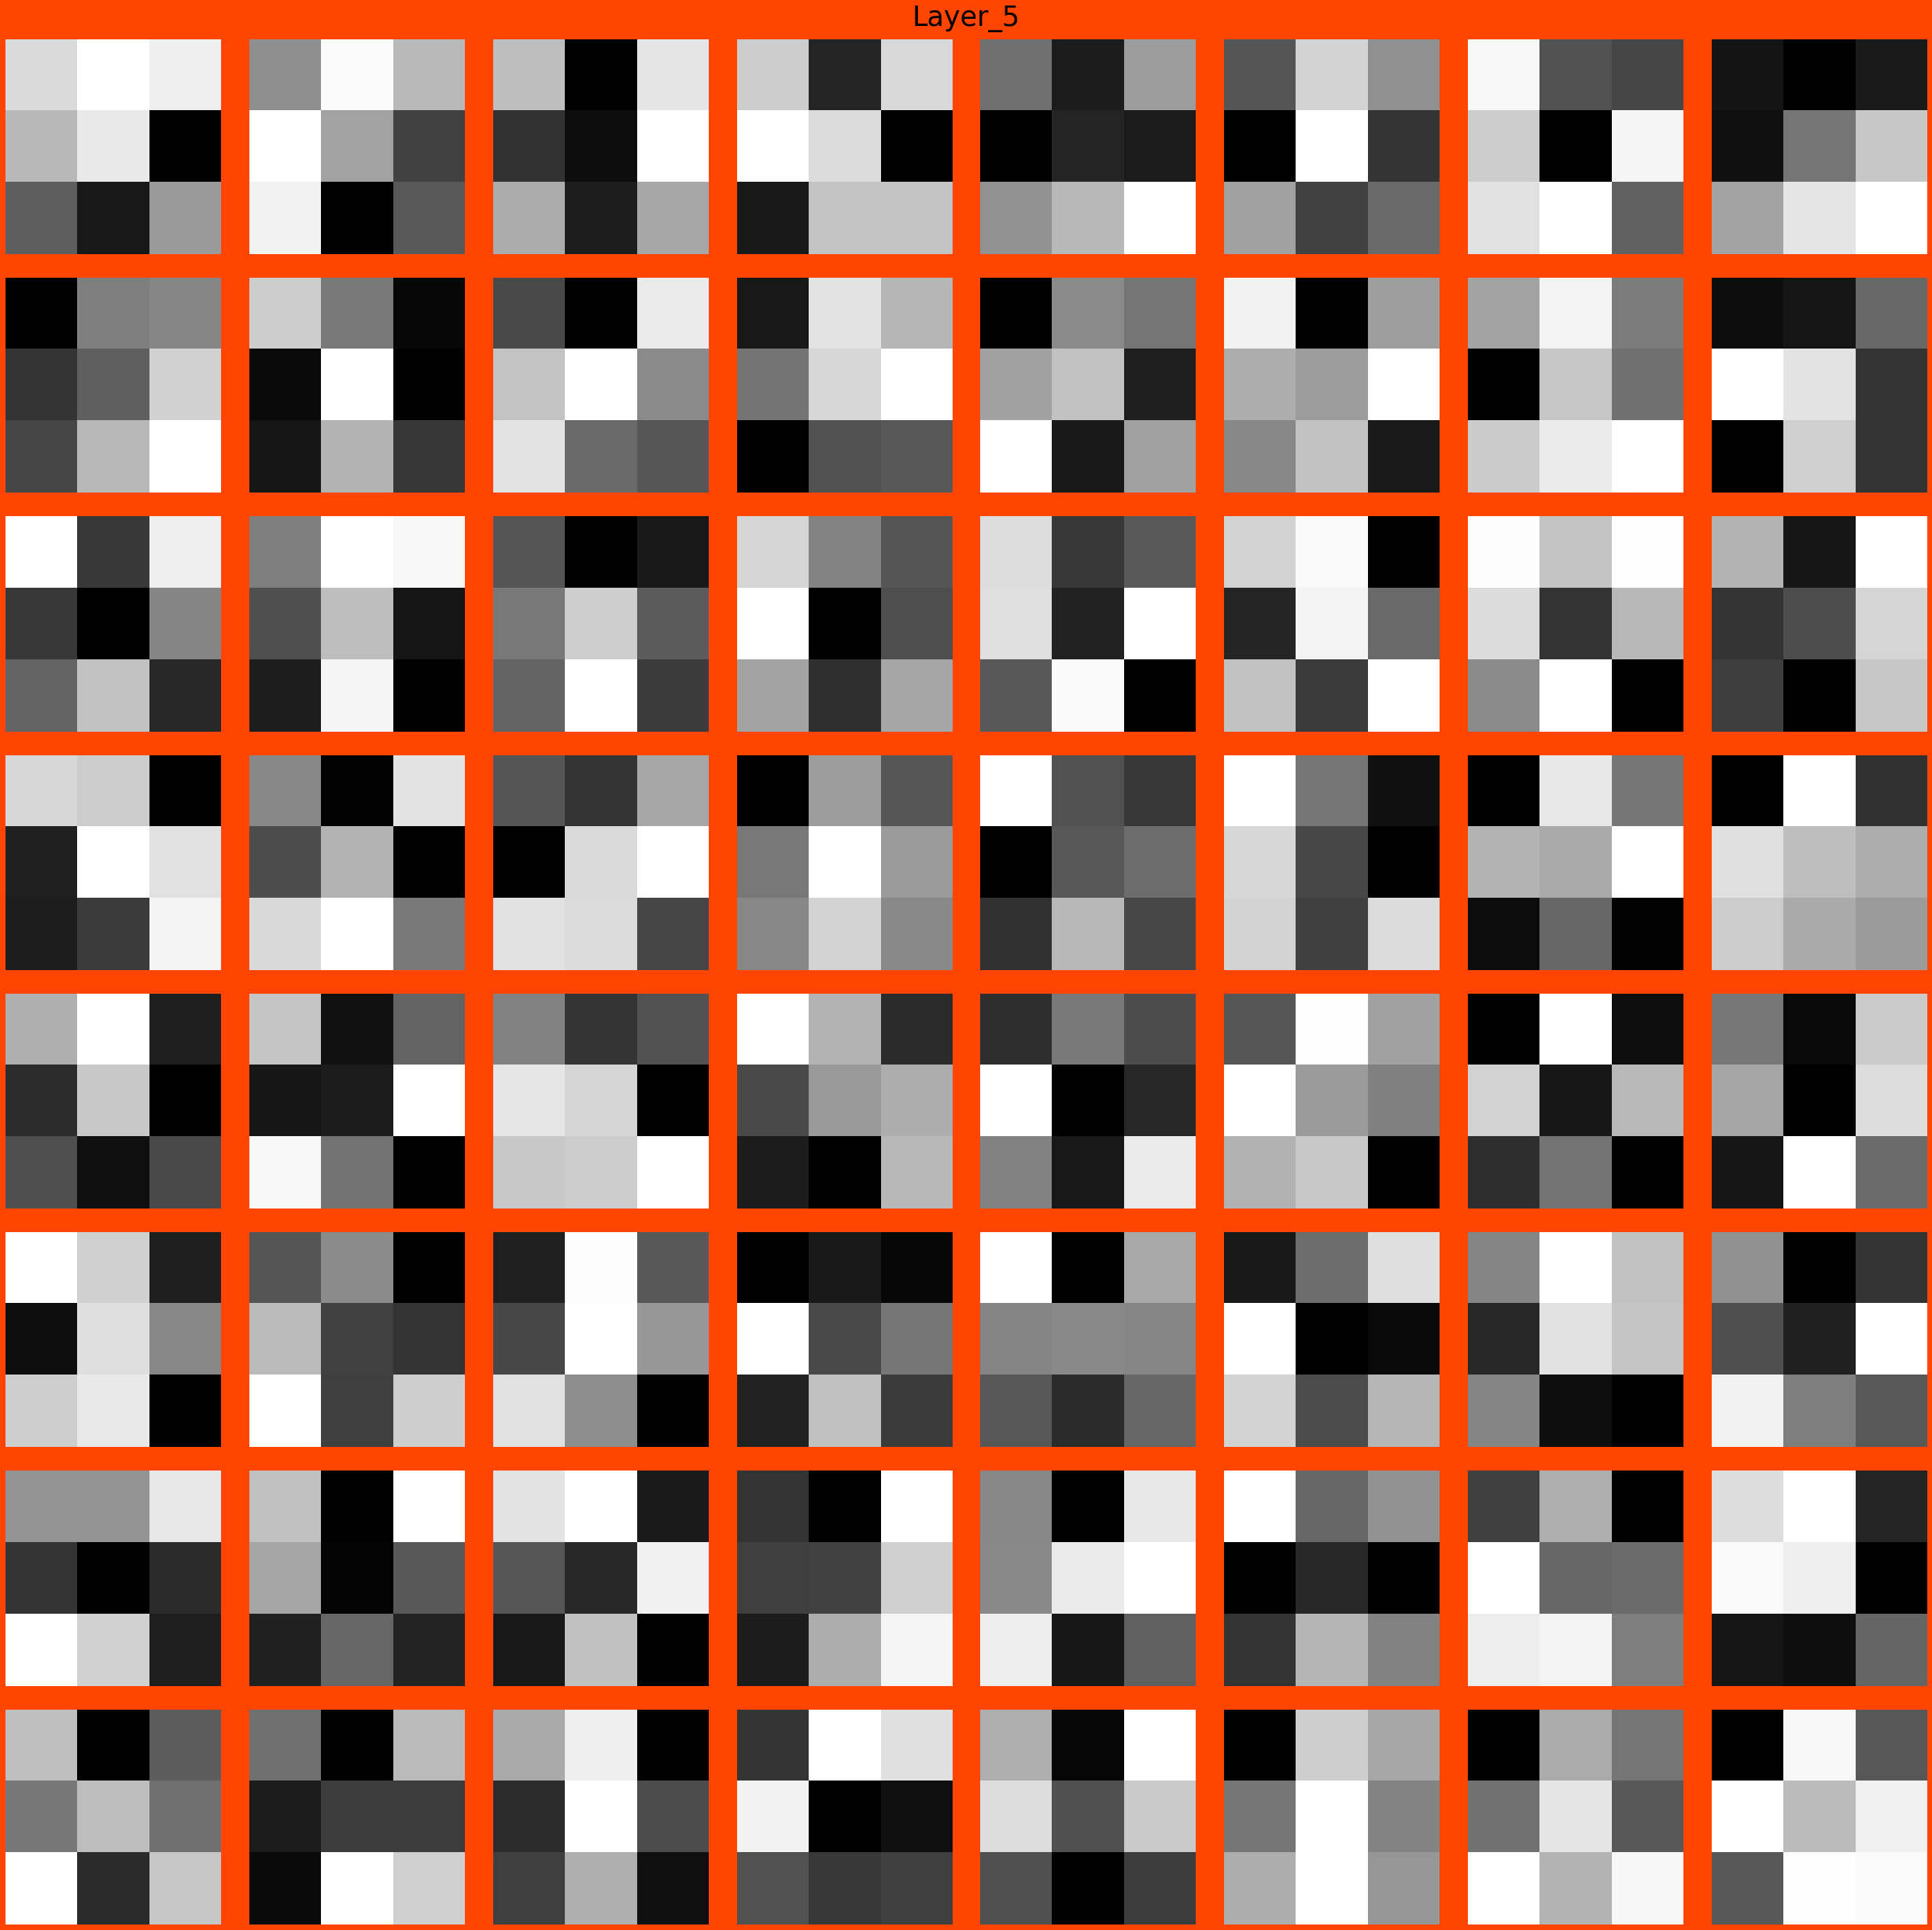

In [93]:
BaseModel.extractFilters()

####################################
# Features of convolutional layers #
####################################



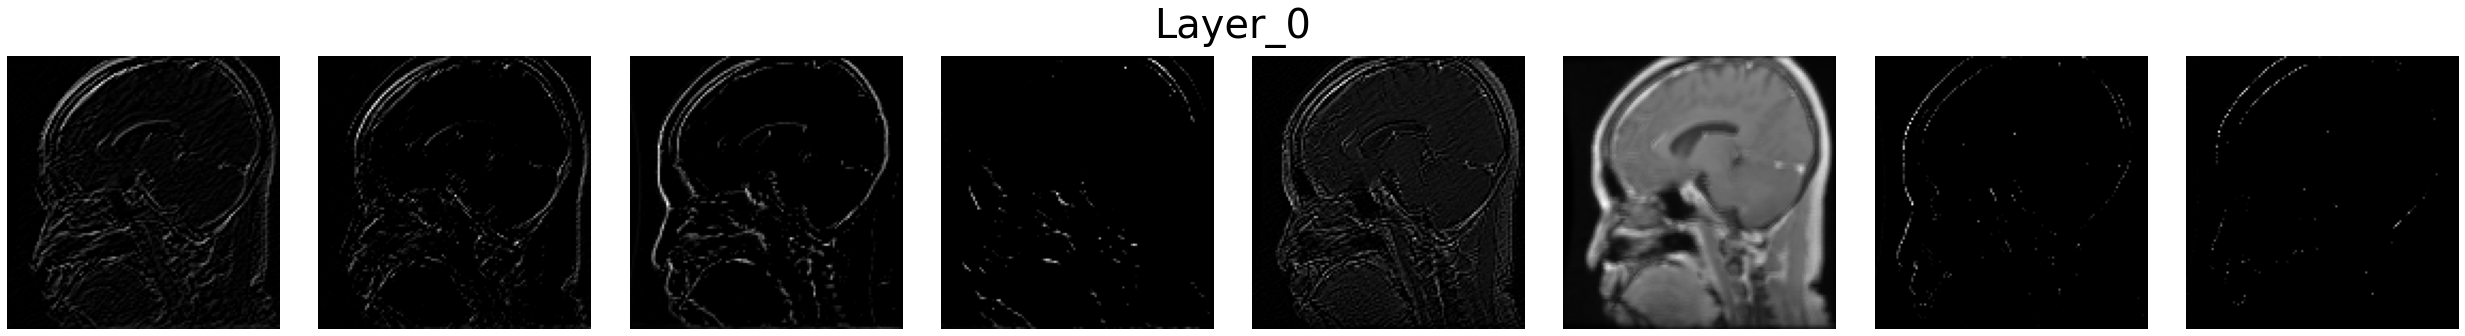

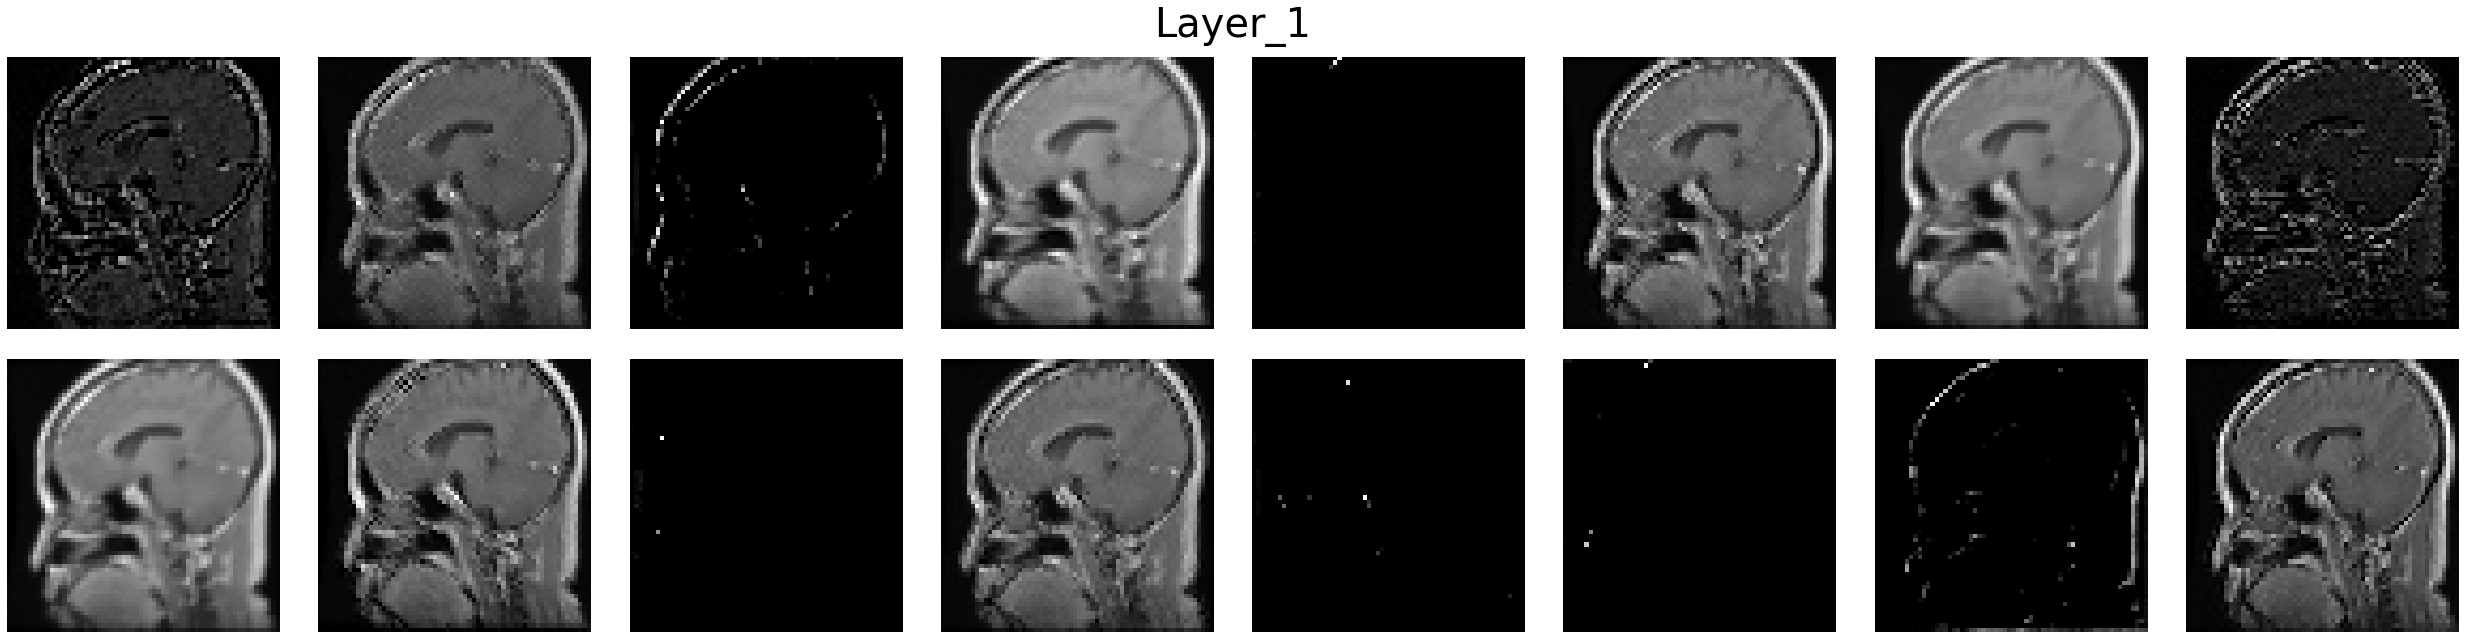

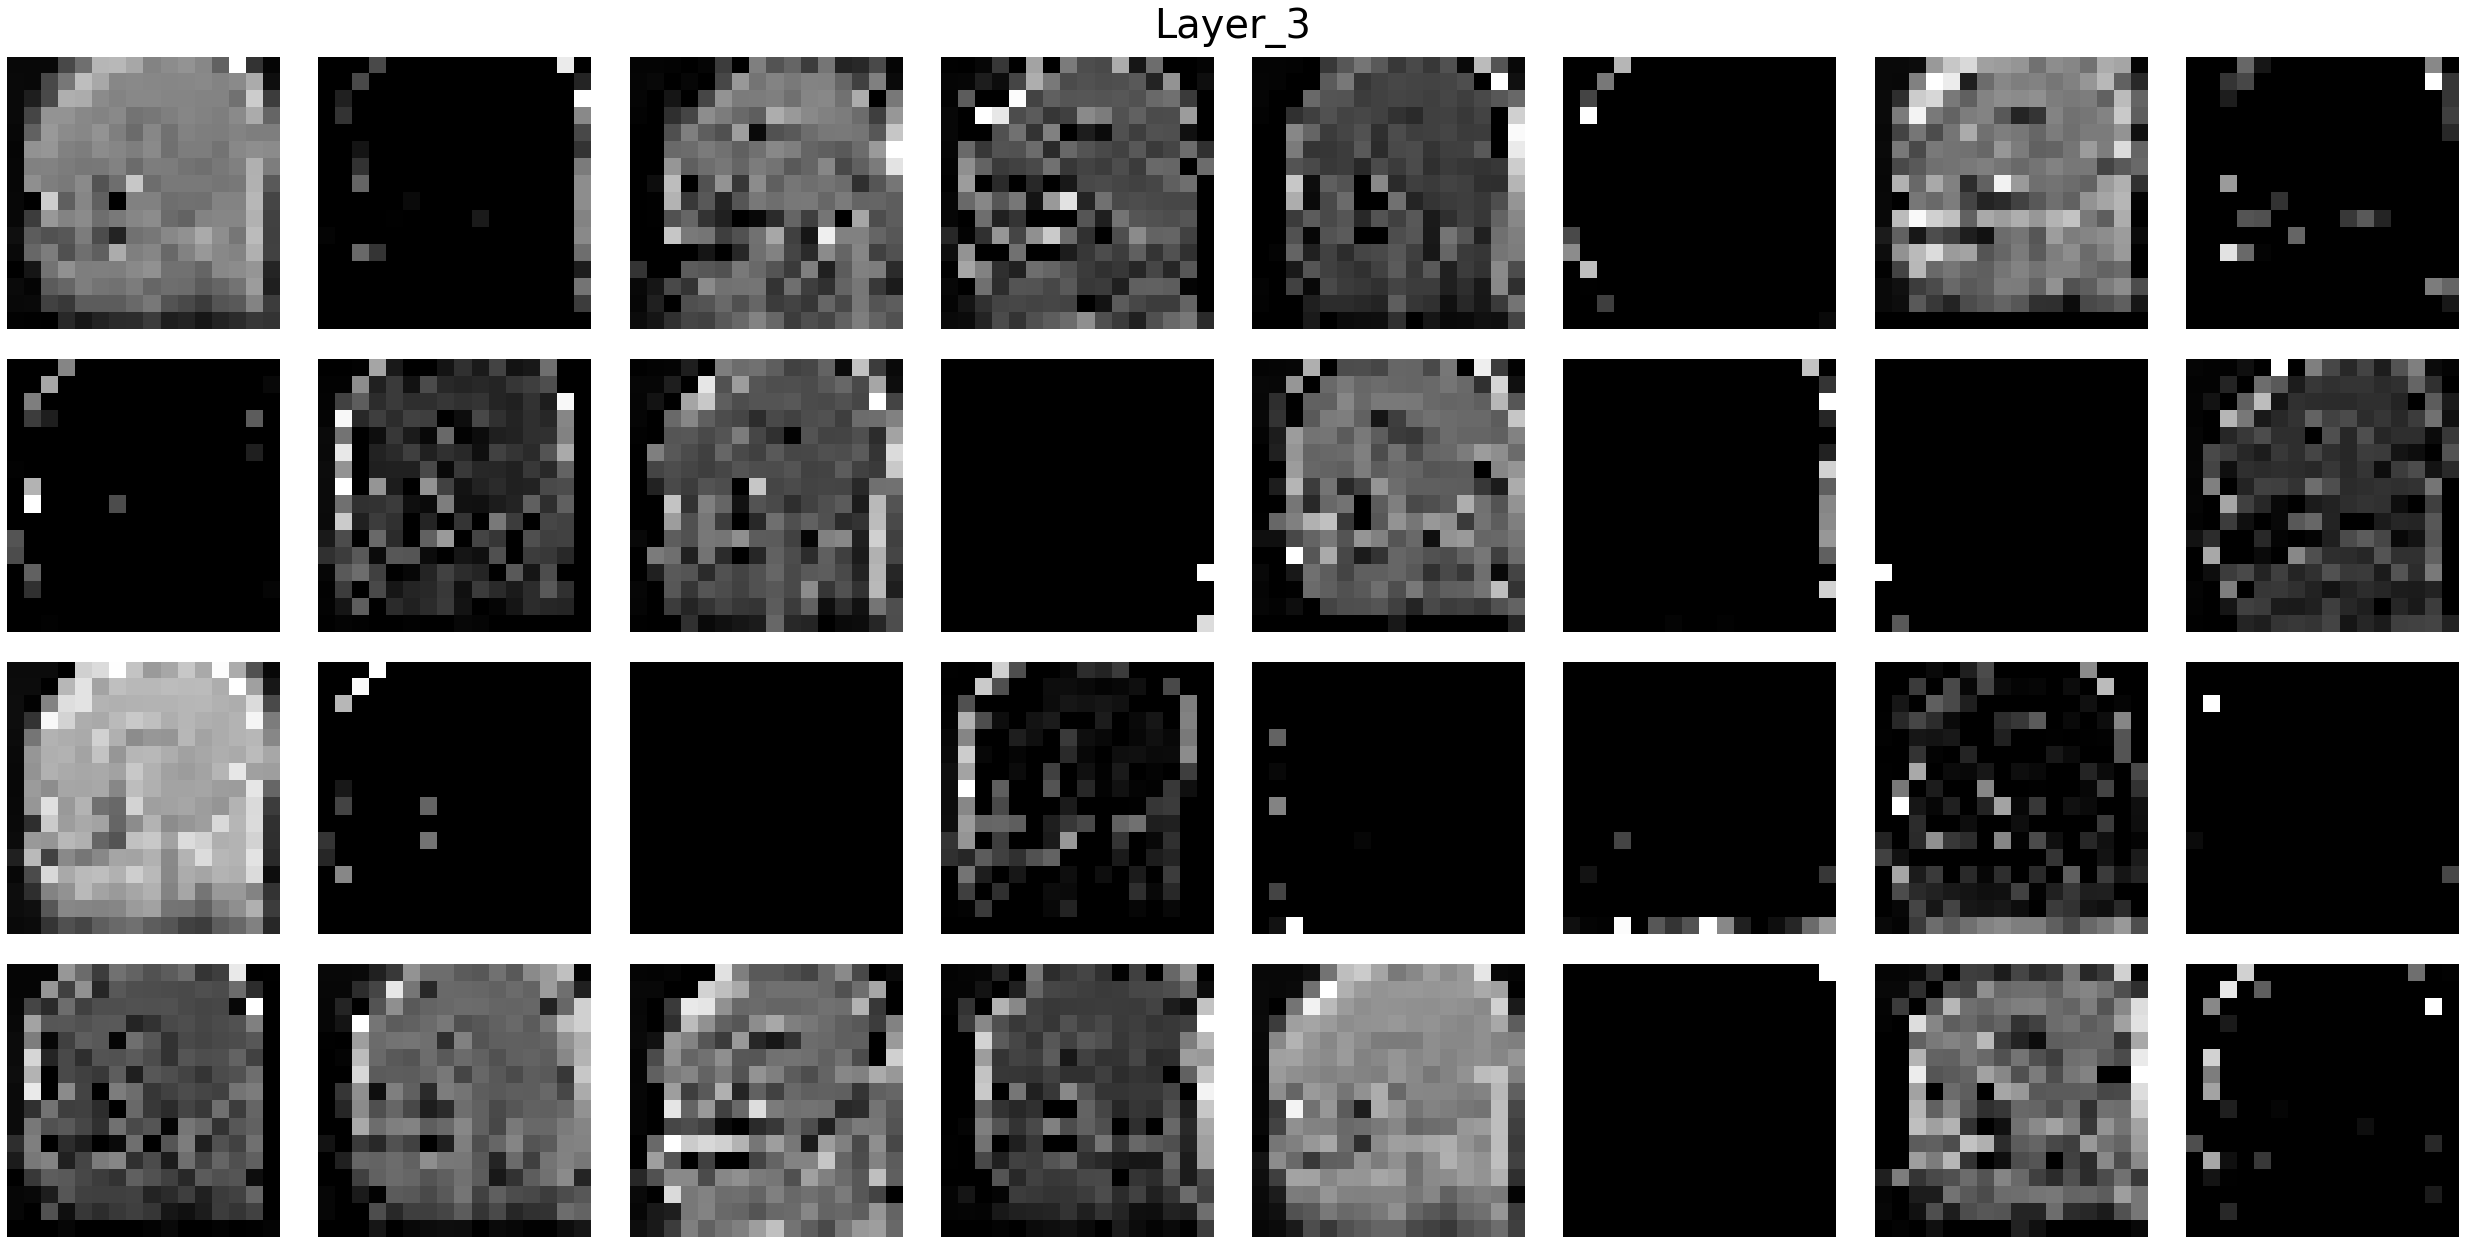

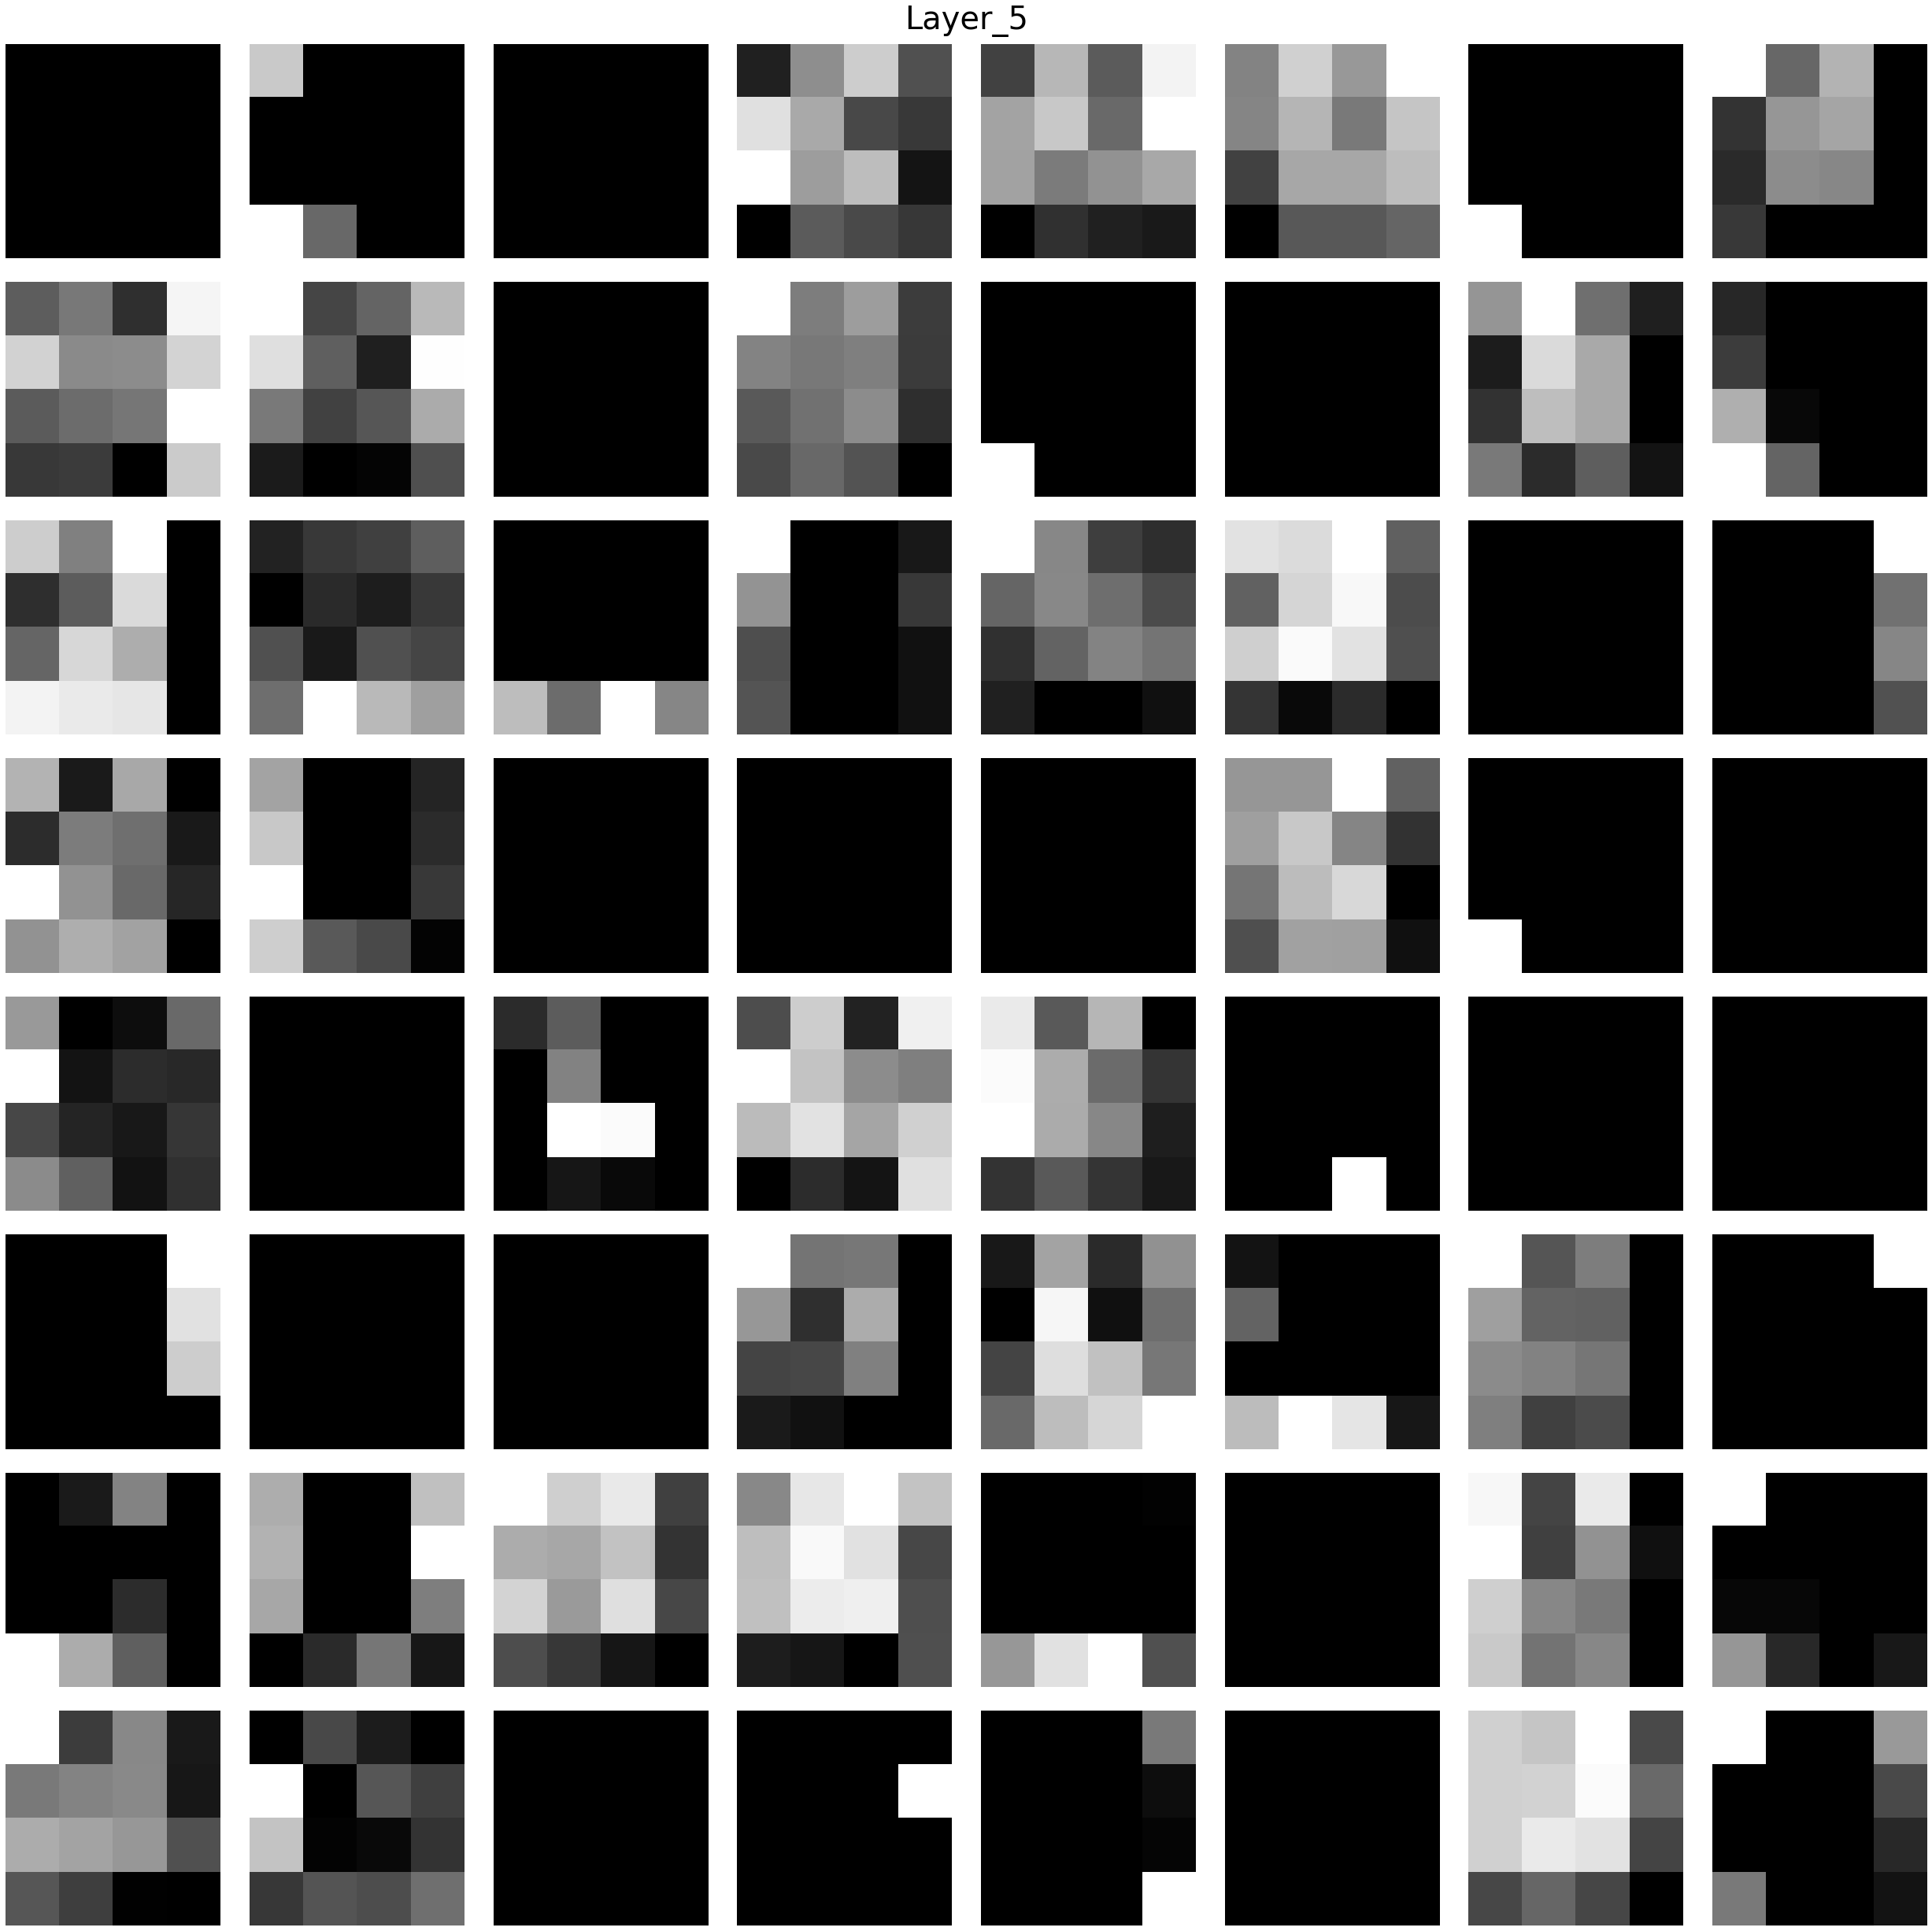

In [102]:
BaseModel.displayFeatureMaps(layer_instance='conv', image=img)

In [ ]:
## Report
---

##### Runtime environment

In [ ]:
%%bash
python --version
neofetch | grep 'CPU\|GPU'

##### Summary chart

### > * First row is the Base Model.
> * All images are grayscaled.

| #parameters | #epochs | depth | Batch_size | filters |strides| kernel_size| Acitvation | Optimizer | learning_rate | val_f1t |
|:-----------:|:-------:|:-----:|:----------:|:-------:|:-----:|:----------:|------------|:---------:|:-------------:|:-------:|
| 26k         | 10      | 3     | 32         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.79    |
| 26k         | 10      | 3     | 16         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.80    |
| 26k         | 10      | 3     | 8          | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.81    |
| 26k         | 10      | 3     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.75    |
| 22k         | 20      | 2     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.79    |
| 22k         | 25      | 2     | 64         | 8       |1      | 3          | ReLU       | Adam      | 0.001         | 0.79    |
| 101k        | 10      | 3     | 100        | 16      |1      | 3          | ReLU       | Adam      | 0.001         | 0.70    |
| 1.5M        | 10      | 3     | 32         | 64      |2      | 3          | ReLU       | Adam      | 0.001         | 0.85    |
| 1.5M        | 20      | 3     | 32         | 64      |2      | 3          | ReLU       | Adam      | 0.001         | 0.89    |
| 1.5M        | 20      | 3     | 32         | 64      |3      | 3          | ReLU       | Adam      | 0.001         | 0.84    |